# Proximinal Policy Optimization

#### Papers Involved
- Proximal Policy Optimization Algorithms: https://arxiv.org/pdf/1707.06347.pdf
- Playing Atari with Deep Reinforcement Learning: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
- REINFORCE: http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf

#### Online Resources
- https://medium.freecodecamp.org/an-intro-to-advantage-actor-critic-methods-lets-play-sonic-the-hedgehog-86d6240171d
- https://medium.com/@jonathan_hui/rl-proximal-policy-optimization-ppo-explained-77f014ec3f12
- https://github.com/dennybritz/reinforcement-learning/issues/34

#### Repos for Inspiration
- https://github.com/OctThe16th/PPO-Keras
- https://github.com/hill-a/stable-baselines
- https://github.com/rlcode/reinforcement-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras import backend as K 

Using TensorFlow backend.


In [8]:
class Environment:
    """ This is a very simple custom environment used for debugging and testing.
    The observation at timestep t is sin(2*t*pi/20)
    The agent starts at position 0
    The action space is one of 3 discrete moves:
        0: add 0.25 to the agent's position
        1: subtract 0.25 from the agent's position
        2: don't do anything
    
    The agent is rewarded +1 if, after moving, it's position at timestep t is within
    a distance of 0.25 from the observation.
    The agent is punished with -1 if, after moving, it's position is outside
    a distance of 0.5 from the observation.
    Otherwise, a reward of 0 is given.
    
    The environment terminates when the step hits max_steps (default 20)
    """
    def __init__(self):
        self.n_actions = 3
        self.n_obs = 2
        self.max_steps = 20
        self.space = np.sin(np.linspace(0,2*np.pi,self.max_steps))
        
    def reset(self):
        self.x = 0
        self.target = self.space[self.x]
        self.agent = self.space[self.x]
        self.state = [self.target, self.agent]
        
        self.x_data = []
        self.target_data = []
        self.agent_data = []
        return np.array(self.state)
    
    def step(self, action):
        self.x += 1
        self.target = self.space[self.x]
        if action == 0:
            pass
        if action == 1:
            self.agent += 0.25
        if action == 2:
            self.agent -= 0.25
            
        self.state = [self.target, self.agent]
        
        dist = abs(self.target - self.agent)
        reward = 0
        if dist < 0.25:
            reward = 1.
        if dist > 0.5:
            reward = -1.
            
        done = False
        if self.x >= self.max_steps - 1:
            done = True
            
        self.x_data.append(self.x)
        self.target_data.append(self.target)
        self.agent_data.append(self.agent)
            
        return np.array(self.state), reward, done, {}
    
    def get_render_data(self):
        return self.x_data, self.target_data, self.agent_data
    
    def render(self):
        plt.plot(self.x_data, self.target_data, '.')
        plt.plot(self.x_data, self.agent_data, '.')
        plt.show()

In [9]:
class Agent:
    def __init__(self, n_obs, n_actions,
                epsilon=0.2, entropy_loss=1e-3, actor_lr=0.001, critic_lr=0.005,
                hidden_size=128, epochs=10, batch_size=64, buffer_size=256):
        # Clear Tensorflow session and set some metadata
        K.clear_session()
        self.n_obs = n_obs
        self.n_actions = n_actions
        
        # Set hyperparameters
        self.epsilon = epsilon
        self.entropy_loss = entropy_loss
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        
        # Build Actor and Critic models
        self.actor = self.build_actor() 
        self.critic = self.build_critic()

    def proximal_policy_optimization_loss(self, advantage, old_pred):
        # Defines the PPO loss to be used during actor optimization
        def loss(y_true, y_pred):
            # y_true is one-hot vector denoting the action taken
            # y_pred is the output of the actor neural network
            # for the given observation
            #
            # e.g., y_true = [0,1,0], y_pred = [0.2, 0.5, 0.3]
            # so prob = y_true * y_pred = [0, 0.5, 0]
            prob = y_true * y_pred
            
            # old_pred is the actor's previous probabilty distribution
            # for the given observation
            #
            # e.g., y_true = [0,1,0], old_pred = [0.2, 0.4, 0.4]
            # so prob = y_true * old_pred = [0, 0.4, 0]
            old_prob = y_true * old_pred
            
            # r is the ratio of the old probability to the new one
            #
            # e.g., r = prob/old_prob = [inf, 0.5/0.4, inf]
            r = prob/(old_prob + 1e-10)
            
            # the clip the values, take the mean, add an entropy bonus for exploration
            # K.mean computes the mean over all dimensions (left with a scaler)
            # K.minimum selects the minimum of the two args
            # K.clip clips the value 'r' to be in 1 +/- epsilon
            return -K.mean(
                K.minimum(
                    r * advantage, 
                    K.clip(r, min_value=1-self.epsilon, max_value=1+self.epsilon) * advantage)
                + self.entropy_loss * (prob * K.log(prob + 1e-10)))
        return loss
    
    def build_actor(self):
        # actor has three inputs: the current state, the advantage,
        # and the agent's predicted probability for the given observation
        state_inputs = Input(shape=(self.n_obs,))
        advantage = Input(shape=(1,))
        old_pred = Input(shape=(self.n_actions,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # the output is a probability distribution over the actions
        out_actions = Dense(self.n_actions, activation='softmax')(x)

        model = Model(inputs=[state_inputs, advantage, old_pred],
                      outputs=[out_actions])
        
        # compile the model using our custom loss function
        model.compile(optimizer=Adam(lr=self.actor_lr),
                      loss=[self.proximal_policy_optimization_loss(
                          advantage=advantage,
                          old_pred=old_pred)])
        return model
    
    def build_critic(self):
        # critic recieves the observation as input
        state_inputs = Input(shape=(self.n_obs,))
        
        # hidden layers
        x = Dense(self.hidden_size, activation='relu')(state_inputs)
        x = Dense(self.hidden_size, activation='relu')(x)
        
        # we predict the value of the current observation
        # i.e., cumulative discounted reward
        predictions = Dense(1, activation='linear')(x)

        model = Model(inputs=state_inputs, outputs=predictions)
        model.compile(optimizer=Adam(lr=self.critic_lr),
                      loss='mse')
        return model
    
    def get_action(self, observation):
        # Predict the probability destribution of the actions as a vactor
        prob = self.actor.predict([observation.reshape(1,self.n_obs), 
                                   DUMMY_VALUE, 
                                   DUMMY_ACTION])
        prob = prob.flatten()
        
        # Sample an action as a scaler
        action = np.random.choice(self.n_actions, 1, p=prob)[0]
        
        # Vectorize the action as a one-hot encoding
        action_vector = np.zeros(self.n_actions)
        action_vector[action] = 1
        
        return action, action_vector, prob
    
    def train_batch(self, observations, actions, probabilities, rewards):
        # limit our data to the buffer_size
        obs = observations[:self.buffer_size]
        acts = actions[:self.buffer_size]
        probs = probabilities[:self.buffer_size]
        rews = rewards[:self.buffer_size]
        
        # our 'old probs' are really just the batches probs
        old_probs = probs
        
        # Calculate advantages
        values = self.critic.predict(obs)
        advs = rews - values
            
        # Train the actor and critic on the batch data
        self.actor.fit([obs, advs, old_probs], [acts],
                       batch_size=self.batch_size, shuffle=True,
                       epochs=self.epochs, verbose=False)
        self.critic.fit([obs], [rews],
                       batch_size=self.batch_size, shuffle=True,
                        epochs=self.epochs, verbose=False)

In [10]:
env = Environment()
NUM_OBS = env.n_obs
NUM_ACTS = env.n_actions
CUSTOM_ENVIRONMENT = True

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)

In [ ]:
import gym

env_names = ['CartPole-v1', 'LunarLander-v2','Acrobot-v1', 'MountainCar-v0']
env = gym.make(env_names[0])
NUM_OBS = env.observation_space.shape[0]
NUM_ACTS = env.action_space.n
CUSTOM_ENVIRONMENT = False

agent = Agent(n_actions=NUM_ACTS, n_obs=NUM_OBS)

Episode: 70
Reward : -8.0
Average: -7.057142857142857
----------



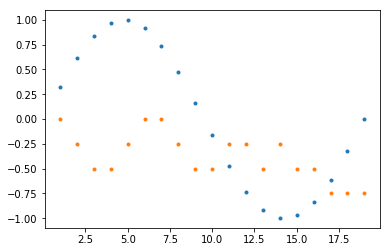

Episode: 140
Reward : -2.0
Average: -3.55
----------



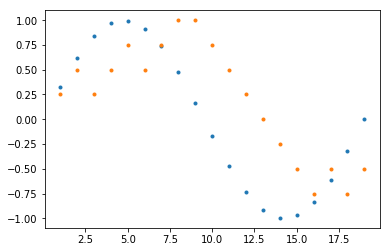

Episode: 210
Reward : 8.0
Average: 3.37
----------



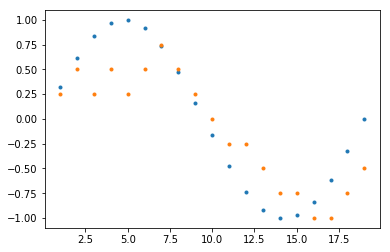

Episode: 280
Reward : 13.0
Average: 10.64
----------



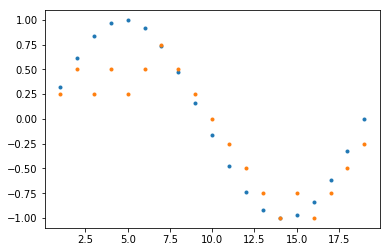

Episode: 350
Reward : 18.0
Average: 14.92
----------



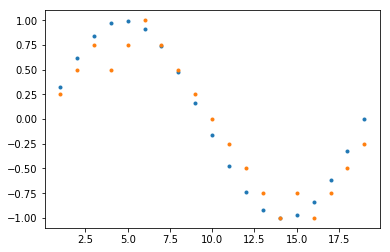

Episode: 420
Reward : 19.0
Average: 13.29
----------



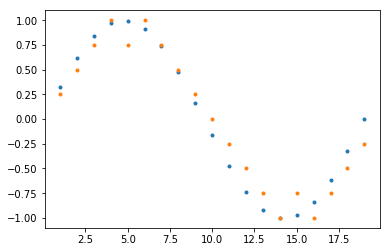

Episode: 490
Reward : 19.0
Average: 15.64
----------



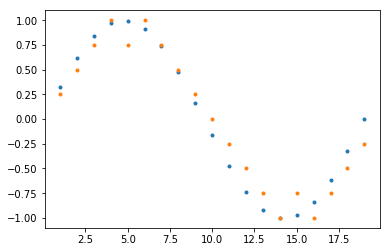

Episode: 560
Reward : 19.0
Average: 17.88
----------



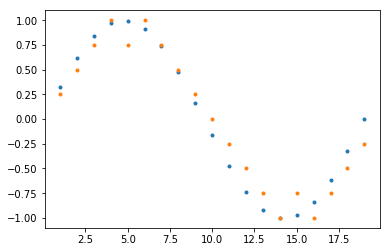

Episode: 630
Reward : 16.0
Average: 15.55
----------



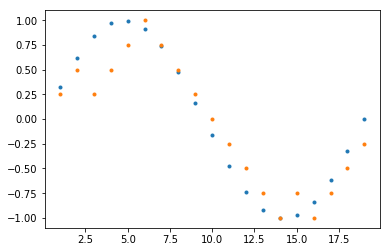

Episode: 700
Reward : 9.0
Average: 16.59
----------



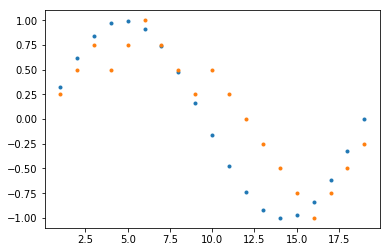

Episode: 770
Reward : 16.0
Average: 14.41
----------



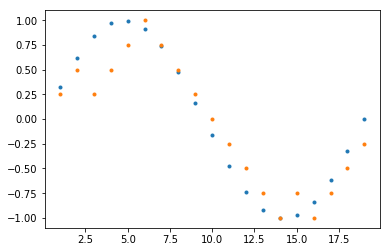

Episode: 840
Reward : 19.0
Average: 16.54
----------



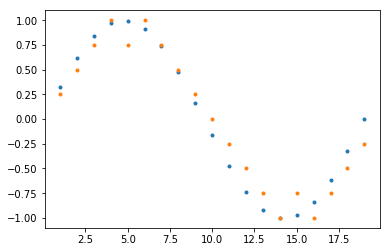

Episode: 910
Reward : 18.0
Average: 17.8
----------



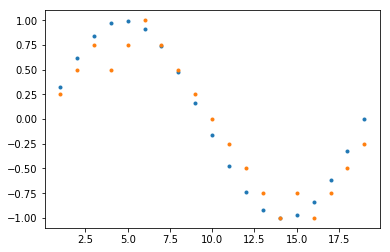

Episode: 980
Reward : 19.0
Average: 17.89
----------



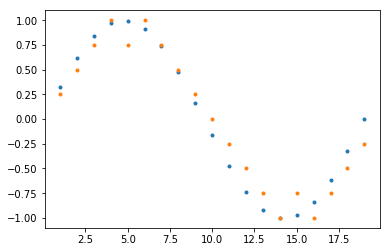

In [11]:
gamma = 0.99
episode = 0
episodes = 1001
reward_history = []

# When we want predictions of actions, we need to pass in three things:
# the observation, the old prob, and the advantage.
# Here, we just created data to spoof the last two.
DUMMY_ACTION, DUMMY_VALUE = np.zeros((1, NUM_ACTS)), np.zeros((1, 1))

# reset the environment
observation = env.reset()

# Collect a batch of samples
while episode < episodes:
    # 'Master Batch' that we add mini batches to
    batch = {
        'observation': [],
        'action_vector': [],
        'probability': [],
        'reward': []
    }
    
    # Mini batch which contains a single episode's data
    tmp_batch = {
        'observation': [],
        'action_vector': [],
        'probability': [],
        'reward': []
    }
    
    # While we don't hit the buffer size with our master batch...
    while len(batch['observation']) < agent.buffer_size:
        # Get the action (scalar), action vector (one-hot vector), 
        # and probability distribution (vector) from the current observation
        action, action_vector, prob = agent.get_action(observation)
        
        # Get the next observation, reward, done, and info for taking an action
        next_observation, reward, done, info = env.step(action)
        
        # Append the data to the mini batch
        tmp_batch['observation'].append(observation)
        tmp_batch['action_vector'].append(action_vector)
        tmp_batch['probability'].append(prob)
        tmp_batch['reward'].append(reward)
        
        # The current observation is now the 'next' observation
        observation = next_observation

        # if the episode is at a terminal state...
        if done:
            # log some reward data (for plotting)
            reward_data = np.sum(tmp_batch['reward'])
            reward_history.append(reward_data)
            
            # transform rewards based to discounted cumulative rewards
            for j in range(len(tmp_batch['reward']) - 2, -1, -1):
                tmp_batch['reward'][j] += tmp_batch['reward'][j + 1] * gamma
                
            # for each entry in the mini batch...
            for i in range(len(tmp_batch['observation'])):
                # we unpack the data
                obs = tmp_batch['observation'][i]
                act = tmp_batch['action_vector'][i]
                prob = tmp_batch['probability'][i]
                r = tmp_batch['reward'][i]
                
                # and pack it into the master batch
                batch['observation'].append(obs)
                batch['action_vector'].append(act)
                batch['probability'].append(prob)
                batch['reward'].append(r)
            
            # if we're using my custom environment,
            # we record some more data for plotting
            if CUSTOM_ENVIRONMENT:
                x_data, target_data, agent_data = env.get_render_data()
                
            # reset the environment
            observation = env.reset()
            
            # reset the mini batch
            tmp_batch = {
                'observation': [],
                'action_vector': [],
                'probability': [],
                'reward': []
            }
            
            # increment the episode count
            episode += 1
                
    # we've filled up our master batch, so we unpack it into numpy arrays
    observations = np.array(batch['observation'])
    actions = np.array(batch['action_vector'])
    probabilities = np.array(batch['probability'])
    rewards = np.array(batch['reward'])    
    rewards = np.reshape(rewards, (len(batch['reward']), 1))
    
    # train the agent on the batched data
    agent.train_batch(observations, actions, probabilities, rewards)
    
    # every 10th episode, log some stuff
    if episode % 10 == 0:
        print('Episode:', episode)
        print('Reward :', reward_data)
        print('Average:', np.mean(reward_history[-100:]))
        print('-'*10)
        print()
        if CUSTOM_ENVIRONMENT:
            plt.plot(x_data, target_data, '.')
            plt.plot(x_data, agent_data, '.')
            plt.show()
        if np.mean(reward_history[-100:]) >= 400:
            break

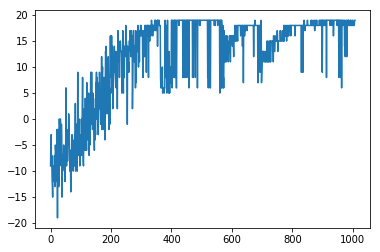

In [12]:
plt.plot(reward_history)
plt.show()